In [1]:
# import common packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.kernel_approximation import RBFSampler, Nystroem


C:\Users\Sandrine Dubroeucq\.conda\envs\mytfenv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\Sandrine Dubroeucq\.conda\envs\mytfenv\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
# Environment description
rewards={(0,3):1,(1,3):-1}

actions={
    (2,0):['U','R'],
    (1,0):['U','D'],
    (0,0):['R','D'],
    (2,1):['R','L'],
    (0,1):['R','L'],
    (2,2):['U','R','L'],
    (1,2):['U','D','R'],
    (0,2):['R','L','D'],
    (2,3):['L'],
}

probs = {
    ((2, 0), 'U'): {(1, 0): 1.0},
    ((2, 0), 'D'): {(2, 0): 1.0},
    ((2, 0), 'L'): {(2, 0): 1.0},
    ((2, 0), 'R'): {(2, 1): 1.0},
    ((1, 0), 'U'): {(0, 0): 1.0},
    ((1, 0), 'D'): {(2, 0): 1.0},
    ((1, 0), 'L'): {(1, 0): 1.0},
    ((1, 0), 'R'): {(1, 0): 1.0},
    ((0, 0), 'U'): {(0, 0): 1.0},
    ((0, 0), 'D'): {(1, 0): 1.0},
    ((0, 0), 'L'): {(0, 0): 1.0},
    ((0, 0), 'R'): {(0, 1): 1.0},
    ((0, 1), 'U'): {(0, 1): 1.0},
    ((0, 1), 'D'): {(0, 1): 1.0},
    ((0, 1), 'L'): {(0, 0): 1.0},
    ((0, 1), 'R'): {(0, 2): 1.0},
    ((0, 2), 'U'): {(0, 2): 1.0},
    ((0, 2), 'D'): {(1, 2): 1.0},
    ((0, 2), 'L'): {(0, 1): 1.0},
    ((0, 2), 'R'): {(0, 3): 1.0},
    ((2, 1), 'U'): {(2, 1): 1.0},
    ((2, 1), 'D'): {(2, 1): 1.0},
    ((2, 1), 'L'): {(2, 0): 1.0},
    ((2, 1), 'R'): {(2, 2): 1.0},
    ((2, 2), 'U'): {(1, 2): 1.0},
    ((2, 2), 'D'): {(2, 2): 1.0},
    ((2, 2), 'L'): {(2, 1): 1.0},
    ((2, 2), 'R'): {(2, 3): 1.0},
    ((2, 3), 'U'): {(1, 3): 1.0},
    ((2, 3), 'D'): {(2, 3): 1.0},
    ((2, 3), 'L'): {(2, 2): 1.0},
    ((2, 3), 'R'): {(2, 3): 1.0},
    ((1, 2), 'U'): {(0, 2): 0.5, (1, 3): 0.5},
    ((1, 2), 'D'): {(2, 2): 1.0},
    ((1, 2), 'L'): {(1, 2): 1.0},
    ((1, 2), 'R'): {(1, 3): 1.0},
  }

policy = {
    (2, 0): 'U',
    (1, 0): 'U',
    (0, 0): 'R',
    (0, 1): 'R',
    (0, 2): 'R',
    (1, 2): 'R',
    (2, 1): 'R',
    (2, 2): 'R',
    (2, 3): 'U'
  }

In [3]:
# define the gridworld  class
class WindyGridWorld():
    
    def __init__(self, rows, columns, start_position):
        self.rows = rows
        self.columns = columns
        #self.all_states = [(i,j) for i in range(rows) for j in range(columns)]
        self.i = start_position[0]
        self.j = start_position[1]
        
    def set_rewards_actions(self, rewards, actions, probs):
        self.rewards = rewards
        self.actions = actions
        self.probs = probs
        self.all_states = set(self.actions.keys()) | set(self.rewards.keys())
        #print (self.all_states)
    
    def set_state(self, s):
        self.i = s[0]
        self.j = s[1]
    
    def current_state(self):
        return self.i,self.j
    
    def reset(self):
        self.i = 2
        self.j = 0
        return self.current_state()
    
    def undo_move(self, action):
        if action in self.actions[(self.i,self.j)]:
            if action == 'U':
                self.i += 1
            elif action == 'R':
                self.j -= 1
            elif action == 'L':
                self.j += 1
            else:
                self.i -= 1
        # should never happen
        assert (self.current_state() in self.all_states)
 
    def move(self, action):
        cur_state = (self.i, self.j)
        a = action
        next_action_prob = self.probs[(cur_state,a)]
        next_actions = list(next_action_prob.keys())
        next_probs = list(next_action_prob.values())
        next_state_idx = np.random.choice(len(next_actions), p=next_probs)
        self.i = next_actions[next_state_idx][0]
        self.j = next_actions[next_state_idx][1]
        return self.rewards.get((self.i,self.j),0)

    def is_terminal (self, s):
        return s not in self.actions
    
    def game_over(self):
        return (self.i,self.j) in self.actions

In [4]:
# define the gridworld  class
class GridWorld():
    
    def __init__(self, rows, columns, start_position):
        self.rows = rows
        self.columns = columns
        #self.all_states = [(i,j) for i in range(rows) for j in range(columns)]
        self.i = start_position[0]
        self.j = start_position[1]
        
    def set_rewards_actions(self, rewards, actions):
        self.rewards = rewards
        self.actions = actions
        self.all_states = set(self.actions.keys()) | set(self.rewards.keys())
        print (self.all_states)
    
    def set_state(self, s):
        self.i = s[0]
        self.j = s[1]
    
    def current_state(self):
        return self.i,self.j

    def reset(self):
        self.i = 2
        self.j = 0
        return self.current_state()
    
    def get_next_state(self, s, a):
        i, j = s[0], s[1]
        #print(f"s : ({i},{j})")
        #print(a)
        #print(self.actions[(i,j)])
        if a in self.actions[(i,j)]:
            if a == 'U':
                i -= 1
            elif a == 'R':
                j += 1
            elif a == 'L':
                j -= 1
            else:
                i += 1
        #print(f"s2 : ({i},{j})")
        return i,j
    
    def undo_move(self, action):
        if action in self.actions[(self.i,self.j)]:
            if action == 'U':
                self.i += 1
            elif action == 'R':
                self.j -= 1
            elif action == 'L':
                self.j += 1
            else:
                self.i -= 1
        # should never happen
        assert (self.current_state() in self.all_states)
 
    def move(self, action):
        if action in self.actions[(self.i,self.j)]:
            if action == 'U':
                self.i -= 1
            elif action == 'R':
                self.j += 1
            elif action == 'L':
                self.j -= 1
            else:
                self.i += 1
        return self.rewards.get((self.i,self.j),0)

    def is_terminal (self, s):
        return s not in self.actions
    
    def game_over(self):
        return (self.i,self.j) in self.actions

In [5]:
def print_values(V,g):
    for i in range(g.rows):
        print("---------------------------")
        for j in range(g.columns):
            v = V.get((i,j),0)
            if v >= 0:
                print(" %.2f|" % v, end="")
            else:
                print("%.2f|" % v, end="")
        print ("")

def print_policy(P,g):
    for i in range(g.rows):
        print("---------------------------")
        for j in range(g.columns):
            a = P.get((i,j),' ')
            print(" %s |" % a, end="")
        print ("")

ACTION_SPACE = ('U', 'D', 'L', 'R')

def init_windy_grid_world_penalized(step_cost, start):
    grid = WindyGridWorld(3,4,start)
    rewards = {
        (2,0):step_cost,
        (1,0):step_cost,
        (0,0):step_cost,
        (2,1):step_cost,
        (0,1):step_cost,
        (2,2):step_cost,
        (1,2):step_cost,
        (0,2):step_cost,
        (2,3):step_cost,
        (0,3):1,
        (1,3):-1
    }
    grid.set_rewards_actions(rewards, actions, probs)
    return grid

def max_dict(d):
    '''
    return the argmax and max value from a dictionnary
    '''
    max_val = max(d.values())
    max_keys = [key for key, val in d.items() if val == max_val]
    return np.random.choice(max_keys), max_val

def epsilon_greedy(Q, state, eps=0.1):
    '''
    return an actions based on the epsilon greedy concept : exploration vs exploitation
    random action if < epx else best action
    '''
    p = np.random.random()
    if p < eps:
        a = np.random.choice(ACTION_SPACE)
    else:
        a = Q[state]
    return a



In [8]:

SMALL_ENOUGH = 1e-3

def gather_samples(grid, n_episodes = 10000):
    '''
    return a dataset to feed a model with X_train dataset 
    Not requested for RBF but it's a more generic implementation
    '''
    samples = []
    for _ in range(n_episodes):
        s = grid.reset()
        samples.append(s)
        while grid.game_over():
            a = np.random.choice(ACTION_SPACE)
            r = grid.move(a)
            s = grid.current_state()
            samples.append(s)
    return samples

class Model:
    '''
    implement the model of the linear regression with the phi transformation
    '''
    def __init__(self, grid):
        '''
        constructor that fit the featurizer phi to data
        '''
        samples = gather_samples(grid)
        self.featurizer = RBFSampler()
        self.featurizer.fit(samples)
        dims = self.featurizer.random_offset_.shape[0]
        
        # initialize linear model weights
        self.w = np.zeros(dims)

    def predict(self, s):
        x = self.featurizer.transform([s])[0]
        return x @ self.w
        
    def grad(self, s):
        x = self.featurizer.transform([s])[0]
        return x
    
    
        
def main(step_cost, tot_iteration):
    
    gamma = 0.9    
    ALPHA = 0.1
        
    # initialize G and returns
    #g = init_grid_world_penalized(step_cost, (2,0))
    g = GridWorld(3,4,(2,0))
    g.set_rewards_actions(rewards=rewards, actions=actions)
    
    print(f"rewards : ")
    print_values(g.rewards,g)
    
    # use the given policy
    
    # create the Model
    model = Model(g)
    mse_per_episode = []
      
    #loop on tot_iteration
    for t in range(tot_iteration):
        if (t+1) % 100 == 0:
            print(t+1)
           
        cur_s = g.reset()
        Vs = model.predict(cur_s)
        n_steps = 0
        episode_err = 0
        
        #compute V based on rewards and next state
        while g.game_over():
            a = epsilon_greedy(policy, cur_s)
            
            r = g.move(a)
            next_s = g.current_state()              
            
            # compute the target
            if g.is_terminal(next_s):
                target = r
            else:
                Vs2 = model.predict(next_s)
                target = r + gamma * Vs2
            
            # equivalent to calculate the gradient descent - small step on w weight for convergence of the loss function 
            # with phi = id
            cur_g = model.grad(cur_s)
            err = target - Vs
            model.w += ALPHA * err * cur_g
            
            # accumulate error
            n_steps += 1
            episode_err += err*err

            # update state
            cur_s = next_s
            Vs = Vs2
            
        #update delta
        mse = episode_err / n_steps
        mse_per_episode.append(mse)
        
    plt.plot(mse_per_episode)
    plt.title("MSE per episode")
    plt.show()
    
    print("finale policy")
    print_policy(policy,g)
    
    # find V
    V = {}
    states = g.all_states
    for s in states:
        if s in g.actions:
            V[s] = model.predict(s)
        else:
            V[s]=0
    
    print("final values:")
    print_values(V,g)
        

{(0, 1), (1, 2), (0, 0), (1, 3), (2, 1), (2, 0), (2, 3), (2, 2), (1, 0), (0, 2), (0, 3)}
rewards : 
---------------------------
 0.00| 0.00| 0.00| 1.00|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


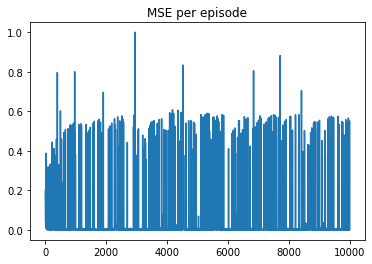

finale policy
---------------------------
 R | R | R |   |
---------------------------
 U |   | R |   |
---------------------------
 U | R | R | U |
final values:
---------------------------
 0.68| 0.74| 0.86| 0.00|
---------------------------
 0.63| 0.00|-1.02| 0.00|
---------------------------
 0.58|-0.08|-0.12|-0.04|


In [9]:
main(-0.05, 10000)